# 🖥️ Environment set-up

📦Import the required packages.

In [1]:
# Universal setup for both Colab and local Jupyter
print("Setting up workshop environment...")

# Clone the repository
!git clone https://github.com/Mark-Kac-Center/MFSCA.git

# Install required packages for FSCA 
print("Installing required packages...")
!pip install -r requirements.txt

# Install required packages for the preprocessing module 
# print("Installing required packages...")
# !pip install -r requirements_ext.txt

print("Setup complete! Ready to begin workshop.")

Setting up workshop environment...
Installing required packages...


Cloning into 'MFSCA'...


  Using cached MFDFA-0.4.3-py3-none-any.whl.metadata (9.2 kB)
Setup complete! Ready to begin workshop.


ERROR: Ignored the following versions that require a different python version: 1.25.0 Requires-Python >=3.9; 1.25.1 Requires-Python >=3.9; 1.25.2 Requires-Python >=3.9; 1.26.0 Requires-Python <3.13,>=3.9; 1.26.1 Requires-Python <3.13,>=3.9; 1.26.2 Requires-Python >=3.9; 1.26.3 Requires-Python >=3.9; 1.26.4 Requires-Python >=3.9; 2.0.0 Requires-Python >=3.9; 2.0.1 Requires-Python >=3.9; 2.0.2 Requires-Python >=3.9; 2.1.0 Requires-Python >=3.10; 2.1.1 Requires-Python >=3.10; 2.1.2 Requires-Python >=3.10; 2.1.3 Requires-Python >=3.10; 2.2.0 Requires-Python >=3.10; 2.2.1 Requires-Python >=3.10; 2.2.2 Requires-Python >=3.10; 2.2.3 Requires-Python >=3.10; 2.2.4 Requires-Python >=3.10; 2.2.5 Requires-Python >=3.10; 2.2.6 Requires-Python >=3.10; 2.3.0 Requires-Python >=3.11; 2.3.1 Requires-Python >=3.11; 2.3.2 Requires-Python >=3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.26.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 

In [1]:
# Verify installation - works on all platforms
import subprocess
import sys

def check_package(package_name):
    try:
        result = subprocess.run([sys.executable, '-m', 'pip', 'show', package_name], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✓ {package_name} is installed")
            return True
        else:
            print(f"✗ {package_name} is NOT installed")
            return False
    except Exception as e:
        print(f"Error checking {package_name}: {e}")
        return False

# Check all required packages
packages = ['MFDFA', 'nibabel', 'numpy', 'packaging']
print("Verifying package installations:")
for pkg in packages:
    check_package(pkg)

Verifying package installations:
✓ MFDFA is installed
✓ nibabel is installed
✓ numpy is installed
✓ packaging is installed


In [ ]:
# ⚠️ I had problems with installing these from requirements on my laptop. On Colab it worked OK, but needs restarting the session.
# !pip install MFDFA==0.4.3
# !pip install ants==0.0.7
# !pip install antspynet==0.2.3
# !pip install antspyx==0.4.2

In [2]:
# Change to repository directory
import os
import sys
os.chdir('MFSCA')

# Add current directory to Python path (works everywhere)
sys.path.append(os.getcwd())

# Load packages
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import fsca

# 💡 Idea
<img src="MFSCA/imgs/flowchart.png" width="600" alt="Flow chart">

# Simulated fractals

Let's start with a model of Fractional Brownion Motion in two dimensions.



⚠️ `! uwaga na working directory!`

## 📁 Load the files

In [109]:
import scipy.io

# Load all FBM2D data into a single array
def load_all_fbm_data():
    data_list = []
    h_values = []
    
    for i in range(9):
        h_val = f'H0{i+1}'
        filename = f'FBM2D_data/FBM2D_{h_val}.mat'
        
        try:
            mat_data = scipy.io.loadmat(filename)
            data_list.append(mat_data[f'FBM2D_{h_val}'])
            h_values.append((i+1)/10)  # Store actual H values: 0.1, 0.2, ..., 0.9
            print(f"Loaded {filename}")
        except FileNotFoundError:
            print(f"File not found: {filename}")
    
    # Stack all arrays along a new axis (first dimension)
    # Shape will be (9, height, width) assuming all images have same dimensions
    fbm_data = np.stack(data_list, axis=0)
    
    return fbm_data, np.array(h_values)

# Load the data
fbm_array, h_values = load_all_fbm_data()
print(f"Combined array shape: {fbm_array.shape}")
print(f"H values: {h_values}")

Loaded FBM2D_data/FBM2D_H01.mat
Loaded FBM2D_data/FBM2D_H02.mat
Loaded FBM2D_data/FBM2D_H03.mat
Loaded FBM2D_data/FBM2D_H04.mat
Loaded FBM2D_data/FBM2D_H05.mat
Loaded FBM2D_data/FBM2D_H06.mat
Loaded FBM2D_data/FBM2D_H07.mat
Loaded FBM2D_data/FBM2D_H08.mat
Loaded FBM2D_data/FBM2D_H09.mat
Combined array shape: (9, 256, 256)
H values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


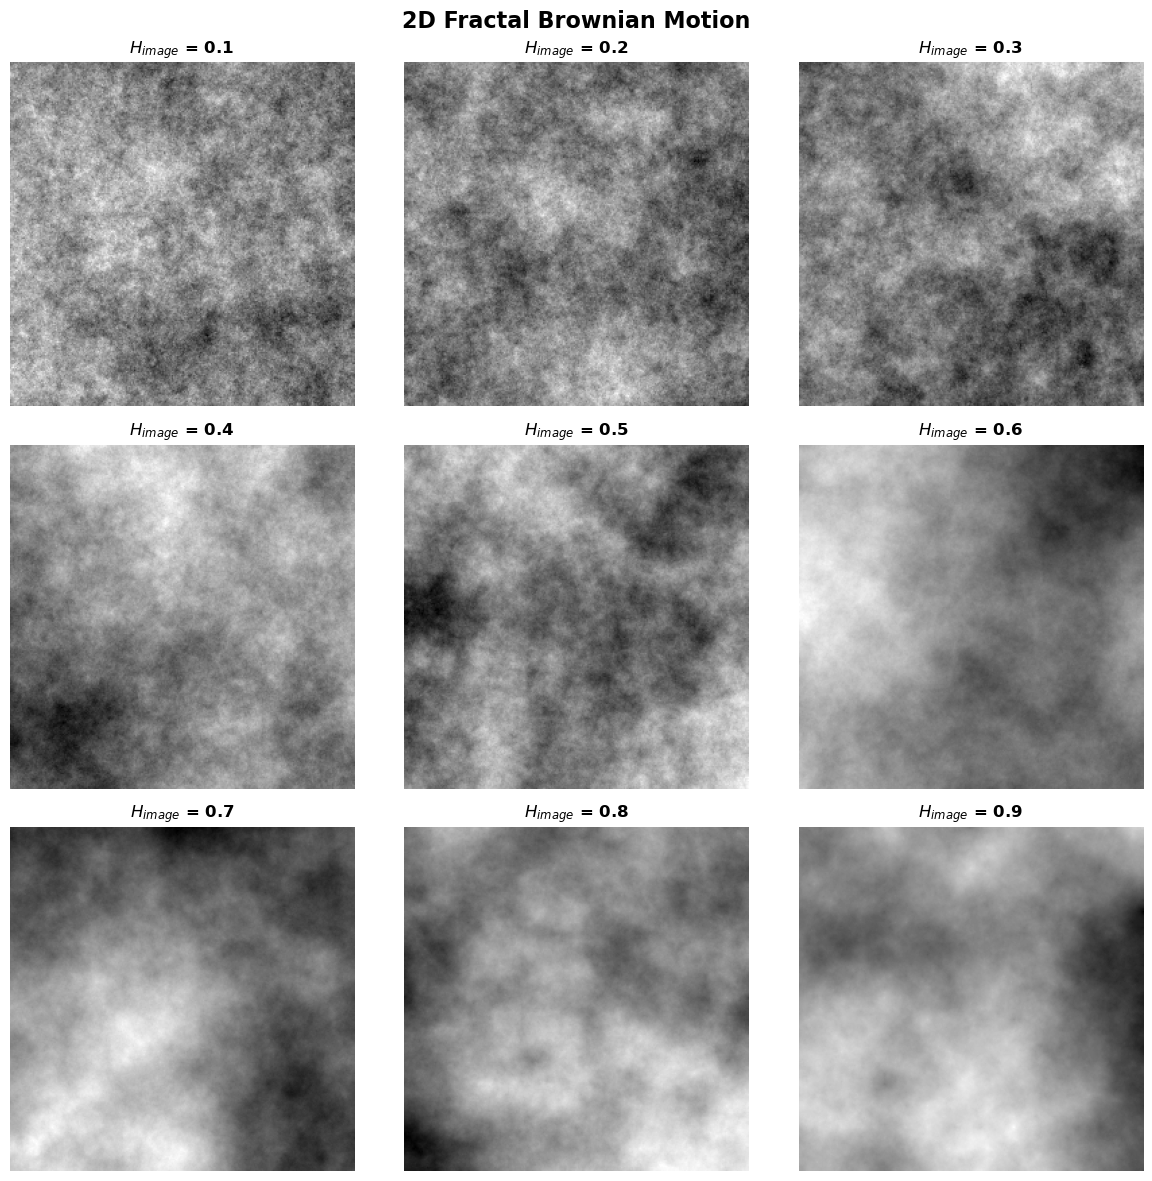

In [115]:
# Plot using the loaded array
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(len(fbm_array)):
    axes[i].imshow(fbm_array[i], cmap='gray')
    axes[i].set_title(f'$H_{{image}}$ = {h_values[i]:.1f}')
    axes[i].axis('off')

plt.suptitle('2D Fractal Brownian Motion', fontsize=16)
plt.tight_layout()
plt.show()

## 🔬 Analysing an Individual 2D image


As a reminder, MF-DFA computes the detrended variances, $F^2(\nu,s)$ for all segments $\nu$ and the respective segment lengths $s$  
and then, for all possible segment lengths, averages them over $\nu$s and the $q$-th order fluctuation function:  

$F_q(s)=\left(\frac{1}{2M_s}\sum_{\nu=1}^{2M_s}\left[F^2(\nu,s)\right]^{q/2}\right)^{1/q},\quad q\in\mathbb{R}\backslash\{0\}.$

For a signal with fractal properties it manifests a power-law-type behaviour (over a wide range of scales $s$):

$F_q(s)\sim s^{h(q)}$.

The family of exponents $h(q)$ are the so-called generalised Hurst exponents.
For a monofractal signal $h(2)\equiv H=\textrm{const.}$  
For short-range correlated time series $H\sim 0.5$.  
For long-range monofractal-correlated time series $H$ deviates from 0.5:  
- $0<H<0.5$ (antipersistent signal)
- $0.5<H<1$ (persistent signal).

Let's load the FSCA pipeline dedicated to 2D images and take a look at the key objects in the pipeline variable.

In [119]:
import fsca
pipe = fsca.pipeline_basic.pipeline_2d()
pipe.run(fbm_array[0])

# key fractal objects:
print('\tpipe.fqs',pipe.fqs.shape)
print('\tpipe.scales',pipe.scales.shape)
print('\tpipe.qorders',pipe.qorders.shape)
print('\tpipe.ghs', pipe.ghs.shape)

	pipe.fqs (31, 40)
	pipe.scales (31,)
	pipe.qorders (40,)
	pipe.ghs (40,)


The dimensions follow:

1. fluctuation function Fq stored as numpy.array with shape: 
```pipe.fqs.shape = (N_SLICES, N_SCALES, N_QORDERS)```

2. scale values stored as numpy.array with shape: 
```pipe.scales.shape = (N_SLICES, N_SCALES)```

3. q orders stored as numpy.array with shape:
```pipe.qorders.shape (N_QORDERS)```

3. generalized Hurst exponents H stored as numpy.array with shape:
```pipe.ghs.shape = (N_SLICES, N_QORDERS)```

where:
- ```N_SCALES``` - number of fluctuation scales $s$
- ```N_QORDERS``` - number of fluctuation orders $q$
- ```N_SLICES``` - number of scans

For 2D images like here, the ```N_SLICES``` dimension disappears.

Now, we are going to plot all the $q$-dependent fluctuation functions `pipe.fqs`  
and we are going to highlight in <span style="color:red">red colour</span> the one for which `pipe.qorders == 2`.  
As a reference, we also plot the line with the slope given by the generalised Hurst exponent `pipe.ghs`  
obtained with the same order $q=2$.

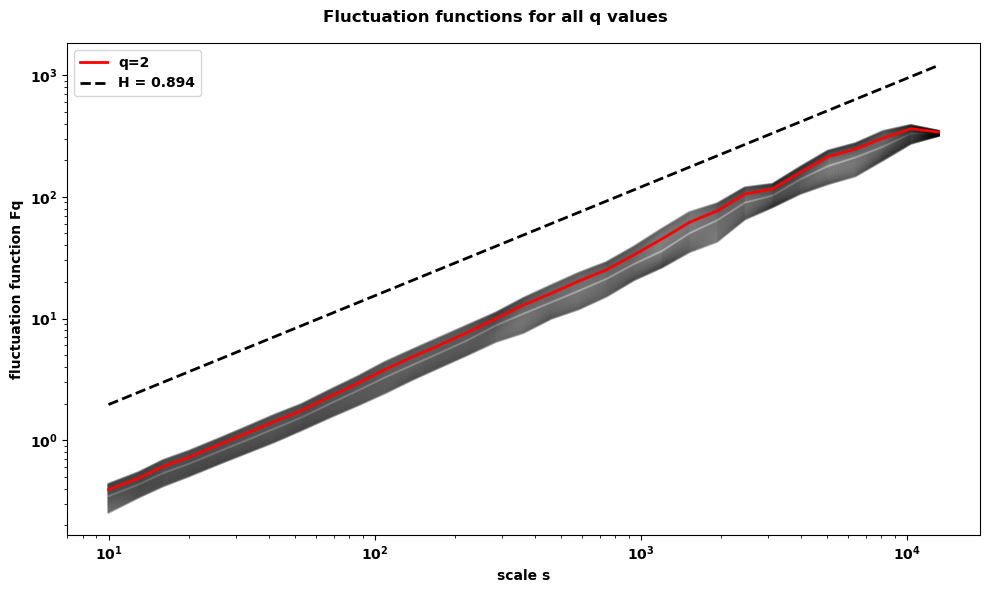

In [126]:
q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()

# Plot all fluctuation functions for different q values
fig, ax = plt.subplots(figsize=(10, 6))
s = pipe.scales

# Plot all q values
for i in range(pipe.fqs.shape[1]):
    ax.plot(s, pipe.fqs[:, i], '-', alpha=0.3, color='black')  # Adjust q labeling as needed

# Highlight the q=2 case
F2 = pipe.fqs[:, q_ix_equal_two]
ax.plot(s, F2, '-', linewidth=2, color='red', label=f'q=2')

# Add the reference line for Hurst exponent
Hurst_H = pipe.ghs[q_ix_equal_two]
h = s**Hurst_H * s[-1]**(-Hurst_H) 
h = h * F2[0] / h[0] * 5 # rescale the reference line for clarity
ax.plot(s, h, '--', color='black', linewidth=2, label=f'H = {Hurst_H:.3f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('fluctuation function Fq')
ax.set_xlabel('scale s')
ax.legend()
fig.suptitle('Fluctuation functions for all q values')
plt.tight_layout()

For now, we are focusing on the monofractal characteristics, i.e. $H = h(2)$.  
Let us check how well the method retrieves the original $H_{image}$.

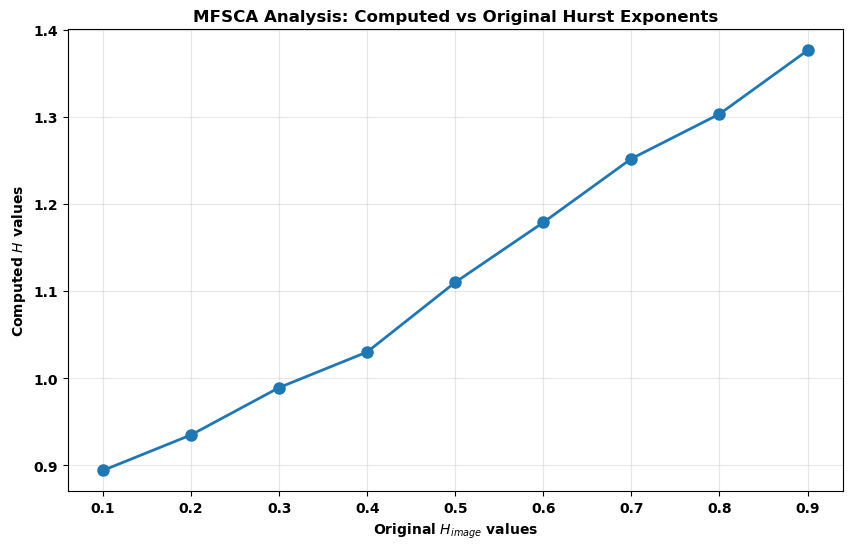

In [141]:
# ⚠️ Czy to się da zrobić w batchu?

# Compute H for all the loaded FBM parameters
H = []
for i in range(9):
    pipe = fsca.pipeline_basic.pipeline_2d()
    pipe.run(fbm_array[i])
    q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()
    H.append(pipe.ghs[q_ix_equal_two])
H = np.array(H)

# Plot computed vs original H values
plt.figure(figsize=(10, 6))
plt.plot(h_values, H, 'o-', markersize=8, linewidth=2, label='Computed H')
plt.xlabel('Original $H_{image}$ values')
plt.ylabel('Computed $H$ values')
plt.title('MFSCA Analysis: Computed vs Original Hurst Exponents')
# plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Komentarz do wykresu:

You can do that faster by using the 3D pipeline `pipeline_3d()`.

In [159]:
pipe = fsca.pipeline_basic.pipeline_3d()
pipe.run(np.transpose(fbm_array)) # Watch the transposition to get 'slices' where you want them.

# Now the dimensions contain N_SLICES (images with consequtive H_image parameter)
print('\tpipe.fqs',pipe.fqs.shape) # (N_SLICES, N_SCALES, N_QORDERS)
print('\tpipe.scales',pipe.scales.shape) # (N_SLICES, N_SCALES)
print('\tpipe.qorders',pipe.qorders.shape) # (N_QORDERS)
print('\tpipe.ghs', pipe.ghs.shape) # (N_SLICES, N_QORDERS)

	pipe.fqs (9, 31, 40)
	pipe.scales (9, 31)
	pipe.qorders (40,)
	pipe.ghs (9, 40)


In [ ]:
q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()
H = pipe.ghs[:,q_ix_equal_two]

# Plot computed vs original H values
plt.figure(figsize=(10, 6))
plt.plot(h_values, H, 'o-', markersize=8, linewidth=2, label='Computed H')
plt.xlabel('Original $H_{image}$ values')
plt.ylabel('Computed $H$ values')
plt.title('MFSCA Analysis: Computed vs Original Hurst Exponents')
# plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🧪 Your Playground

If you would like only the data vectorised into 1D along the Hilbert curve use `pipe.sfcs`.

In [145]:
pipe.sfcs

array([0.48018947, 0.48028527, 0.46521783, ..., 0.72303956, 0.72708719,
       0.72607183])

<!-- Other options:
The type of space-filling algorithm to use. Possible values are ['hilbert','hilbert3d','gilbert','data-driven']
`pipe.map_data_to_sfc2d(sfc_type='data-driven')` -->

## TO DO:

3. mutlifractal chyba nie działa dla 2d? Zamiast (1 slice,qord-1) jest (qord, qord -1)
4. mutlifractal dla 3d daje jakieś dziwne widma alfa....? Patrz niżej.
5. czy chcemy pokazać jakieś inne parametry `pipeline.basic` póki dane wejściowe są proste? 🥼

In [166]:
pipe.calc_falpha()

In [167]:
print('pipe.alphas',pipe.alphas.shape)
print('pipe.fs',pipe.fs.shape)
print('pipe.As', pipe.As.shape)
print('pipe.Ds', pipe.Ds.shape)

pipe.alphas (9, 39)
pipe.fs (9, 39)
pipe.As (9,)
pipe.Ds (9,)


1. alpha values (x-axis on the spectrum plot) with shape:
```pipe.alphas.shape = (N_SLICES, N_QORDERS-1)```

2. f(alpha) values (y-axis on the spectrum plot) with shape:
```pipe.fs.shape = (N_SLICES, N_QORDERS-1)```

3. Spectral asymmetry with shape:
```pipe.As.shape = (N_SLICES)```

4. Spectra widths with shape:
```pipe.Ds.shape (N_SLICES)```

In [178]:
slice_ix = 8
width_D = pipe.Ds[slice_ix]
asym_A = pipe.As[slice_ix]

ix_one = np.argmin(np.abs(pipe.fs[slice_ix] - 1))

y1 = pipe.fs[slice_ix,:ix_one].min()
y2 = pipe.fs[slice_ix,ix_one:].min()
ymin, ymax = min(y1,y2), max(y1,y2)

xmin = pipe.alphas[slice_ix].min()
xmax = pipe.alphas[slice_ix].max()

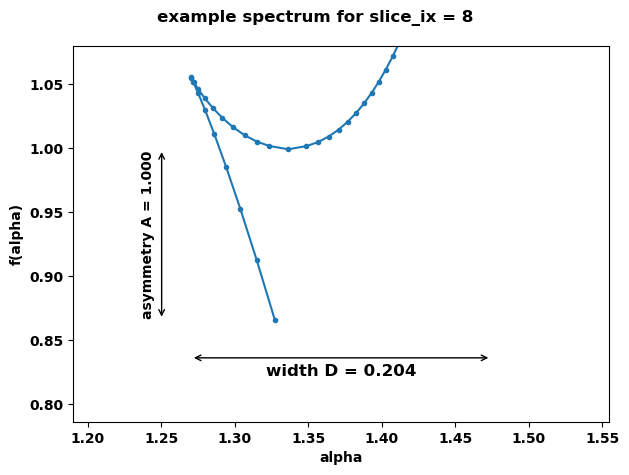

In [179]:
fig, ax = plt.subplots()

ax.plot(pipe.alphas[slice_ix], pipe.fs[slice_ix],'.-')

y0 = ymin-0.03
ax.annotate("", xytext=(xmin, y0), xy=(xmax, y0), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"width D = {width_D:.3f}", xy = ((xmax+xmin)/2,y0),xytext = (0,-4),textcoords = 'offset points', va='top',ha='center', fontsize=12)

x0 = xmin
ax.annotate("", xytext=(xmin-0.02, ymax), xy=(xmin-0.02, ymin), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"asymmetry A = {asym_A:.3f}", xy = (x0-0.02,(ymax+ymin)/2),xytext = (-5,0), textcoords = 'offset points', va='center',ha='right', fontsize=10, rotation = 90)


fig.suptitle(f'example spectrum for slice_ix = {slice_ix}')
ax.set_xlabel('alpha')
ax.set_ylabel('f(alpha)')
do = 0.08
ax.set_xlim(xmin-do,xmax+do)
ax.set_ylim(ymin-do,1+do)
fig.tight_layout()

# Single file MRI

In [3]:
experiment_dir = Path('..') / 'Example_experiment'
data_dir = experiment_dir / 'scans'
output_dir = experiment_dir / 'output'
# state_path = output_dir / f'{slice_axis}'

In [4]:
data_files = list(data_dir.glob("*.nii.gz"))

In [5]:
pipe = fsca.neuro.pipeline_mri()

In [6]:
pipe.run(scan_file = data_files[0], slice_axis = 'x')
# hurst_profile = pipe.get_result()

LinAlgError: SVD did not converge in Linear Least Squares

## Preprocessing example - wyrzucamy

## Fluctuation functions

## Hurst profile

In [12]:
import fsca
pipe = fsca.neuro.pipeline_mri()
pipe.run(scan_file = 'test-data/scanfile.nii.gz', slice_axis = 'z')
hurst_profile = pipe.get_result()

LinAlgError: SVD did not converge in Linear Least Squares

1. alpha values (x-axis on the spectrum plot) with shape:
```pipe.alphas.shape = (N_SLICES, N_QORDERS-1)```

2. f(alpha) values (y-axis on the spectrum plot) with shape:
```pipe.fs.shape = (N_SLICES, N_QORDERS-1)```

3. Spectral asymmetry with shape:
```pipe.As.shape = (N_SLICES)```

4. Spectra widths with shape:
```pipe.Ds.shape (N_SLICES)```

In [53]:
print('pipe.alphas',pipe.alphas.shape)
print('pipe.fs',pipe.fs.shape)
print('pipe.As', pipe.As.shape)
print('pipe.Ds', pipe.Ds.shape)

pipe.alphas (182, 39)
pipe.fs (182, 39)
pipe.As (182,)
pipe.Ds (182,)


In [9]:
width_D = pipe.Ds[slice_ix]
asym_A = pipe.As[slice_ix]

In [10]:
ix_one = np.argmin(np.abs(pipe.fs[slice_ix] - 1))

In [11]:
y1 = pipe.fs[slice_ix,:ix_one].min()
y2 = pipe.fs[slice_ix,ix_one:].min()
ymin, ymax = min(y1,y2), max(y1,y2)

In [12]:
xmin = pipe.alphas[slice_ix].min()
xmax = pipe.alphas[slice_ix].max()

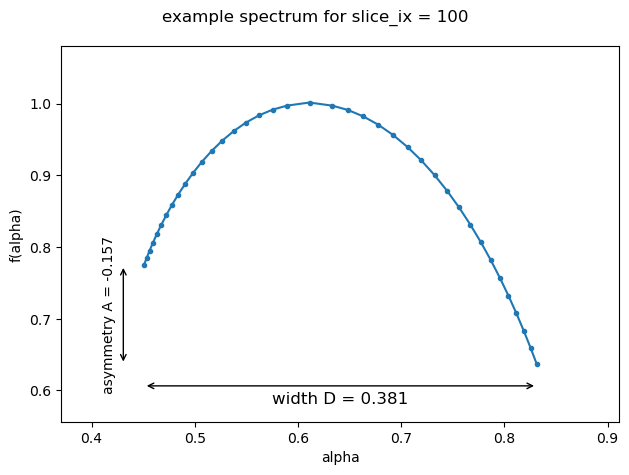

In [34]:
fig, ax = plt.subplots()

ax.plot(pipe.alphas[slice_ix], pipe.fs[slice_ix],'.-')

y0 = ymin-0.03
ax.annotate("", xytext=(xmin, y0), xy=(xmax, y0), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"width D = {width_D:.3f}", xy = ((xmax+xmin)/2,y0),xytext = (0,-4),textcoords = 'offset points', va='top',ha='center', fontsize=12)

x0 = xmin
ax.annotate("", xytext=(xmin-0.02, ymax), xy=(xmin-0.02, ymin), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"asymmetry A = {asym_A:.3f}", xy = (x0-0.02,(ymax+ymin)/2),xytext = (-5,0), textcoords = 'offset points', va='center',ha='right', fontsize=10, rotation = 90)


fig.suptitle(f'example spectrum for slice_ix = {slice_ix}')
ax.set_xlabel('alpha')
ax.set_ylabel('f(alpha)')
do = 0.08
ax.set_xlim(xmin-do,xmax+do)
ax.set_ylim(ymin-do,1+do)
fig.tight_layout()

### Exporting and loading results

# Group analysis MRI?

# Single file fMRI